# Residuals for Cox regression model

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from lifelines import CoxPHFitter, KaplanMeierFitter

Read the data

In [2]:
DatOriginal = pd.read_csv("DatasetsMedicalResearch/Infection in patients on dialysis.dat", sep="\s+")
DatOriginal = DatOriginal.drop('patient', axis=1)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_4107/554960148.py:1: SyntaxWarning: invalid escape sequence '\s'
  DatOriginal = pd.read_csv("DatasetsMedicalResearch/Infection in patients on dialysis.dat", sep="\s+")


In [3]:
DatOriginal.head()

,time,status,age,sex
0,8,1,28,1
1,15,1,44,2
2,22,1,32,1
3,24,1,16,2
4,30,1,10,1


In [4]:
Model = CoxPHFitter().fit(DatOriginal, "time", "status")

In [5]:
Model.print_summary()

<lifelines.CoxPHFitter: fitted with 13 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 13
number of events observed = 12
   partial log-likelihood = -17.23
         time fit was run = 2024-09-22 03:54:07 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.03      1.03      0.03           -0.02            0.08                0.98                1.09
sex       -2.71      0.07      1.10           -4.86           -0.56                0.01                0.57

           cmp to     z    p  -log2(p)
covariate                             
age          0.00  1.16 0.25      2.02
sex          0.00 -2.47 0.01      6.22
---
Concordance = 0.70
Partial AIC = 38.47
log-likelihood ratio test = 6.48 on 2 df
-log2(p) of ll-ratio test = 4.67

Martingale, deviance, Schoenfeld and Scaled Schoenfeld residuals

In [6]:
rM = Model.compute_residuals(DatOriginal, 'martingale')
rD = Model.compute_residuals(DatOriginal, 'deviance')
rS = Model.compute_residuals(DatOriginal, 'schoenfeld')
rSS = Model.compute_residuals(DatOriginal, 'scaled_schoenfeld')

Cox-Snell residuals

In [7]:
rC = pd.DataFrame(
    {'time':rM['time'], 'status':rM['status'], 'cox_snell':-rM['martingale']+rM['status']}
)

Cox-Snell plot

In [8]:
# Fit Kaplan-Meier estimator for Cox-Snell residuals
Surv_rC = KaplanMeierFitter()
Surv_rC.fit(rC['cox_snell'], rC['status'])

# Estimate the cumulative hazard from the KM estimator
rC_KM = (-np.log(Surv_rC.survival_function_['KM_estimate'])).reset_index().drop_duplicates()
rC_KM = rC_KM.rename({'timeline':'cox_snell', 'KM_estimate':'cumulative_hazard'}, axis=1)
rC_KM = rC_KM.reset_index(drop=True)

rC_KM = pd.merge(rC, rC_KM)

Text(0, 0.5, 'Cumulative hazard of residuals')

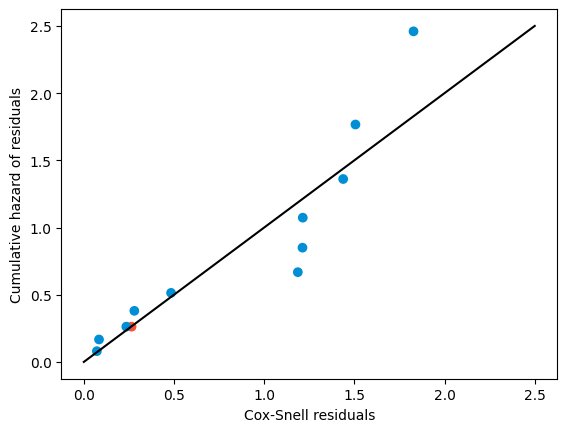

In [9]:
plt.scatter(
    rC_KM['cox_snell'],
    rC_KM['cumulative_hazard'],
    c=np.where(rC_KM['status'], '#008fd5', '#fc4f30')
)
plt.plot([0,2.5], [0,2.5], color='k')
plt.xlabel("Cox-Snell residuals")
plt.ylabel("Cumulative hazard of residuals")

Text(0, 0.5, 'log-cumulative hazard of residuals')

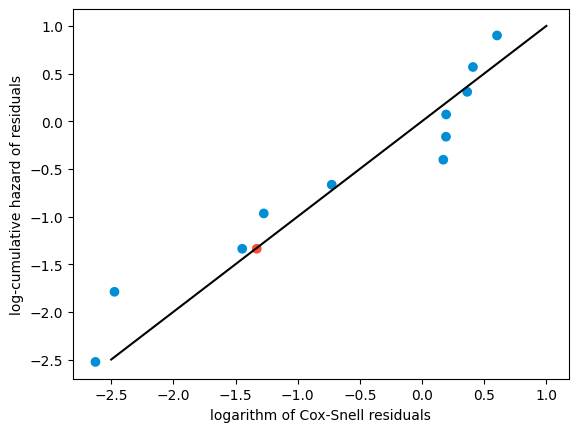

In [10]:
plt.scatter(
    np.log(rC_KM['cox_snell']),
    np.log(rC_KM['cumulative_hazard']),
    c=np.where(rC_KM['status'], '#008fd5', '#fc4f30')
)
plt.plot([-2.5,1], [-2.5,1], color='k')

plt.xlabel("logarithm of Cox-Snell residuals")
plt.ylabel("log-cumulative hazard of residuals")

Martingale and deviance residuals

Text(0, 0.5, 'Martingale residual')

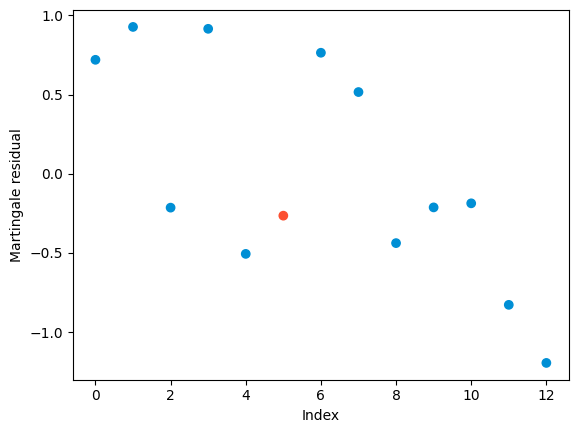

In [11]:
plt.scatter(
    rM.index,
    rM['martingale'],
    c=np.where(rM['status'], '#008fd5', '#fc4f30')
)
plt.xlabel("Index")
plt.ylabel("Martingale residual")

Text(0, 0.5, 'Deviance residual')

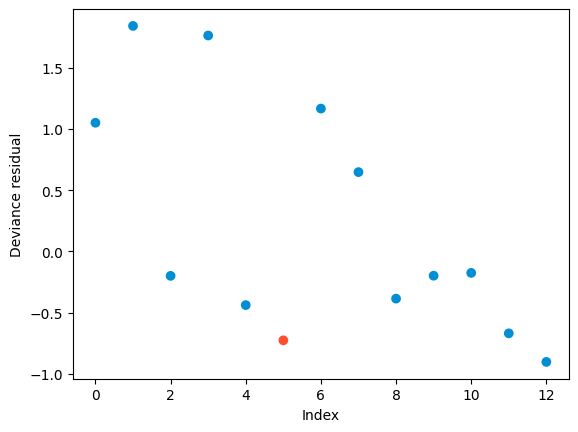

In [12]:
plt.scatter(
    rD.index,
    rD['deviance'],
    c=np.where(rD['status'], '#008fd5', '#fc4f30')
)
plt.xlabel("Index")
plt.ylabel("Deviance residual")

Text(0, 0.5, 'Deviance residual')

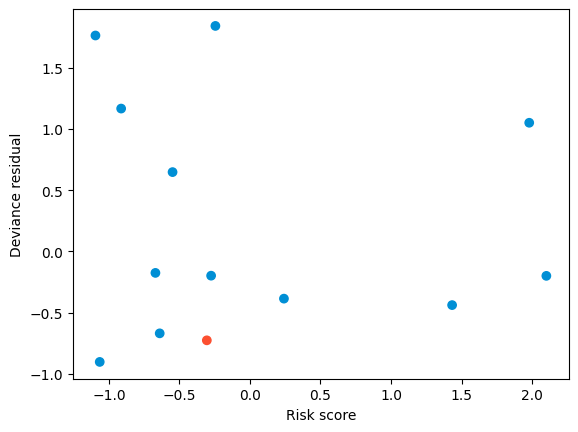

In [13]:
plt.scatter(
    Model.predict_log_partial_hazard(DatOriginal),
    rD['deviance'],
    c=np.where(rD['status'], '#008fd5', '#fc4f30')
)
plt.xlabel("Risk score")
plt.ylabel("Deviance residual")

Check proportional hazard assumption

In [14]:
Model.check_assumptions(DatOriginal)

Proportional hazard assumption looks okay.


[]


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.4977)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4698)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5882)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5853)'>]]

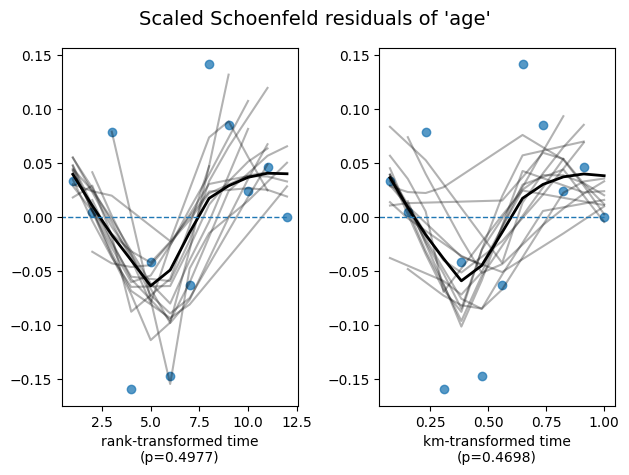

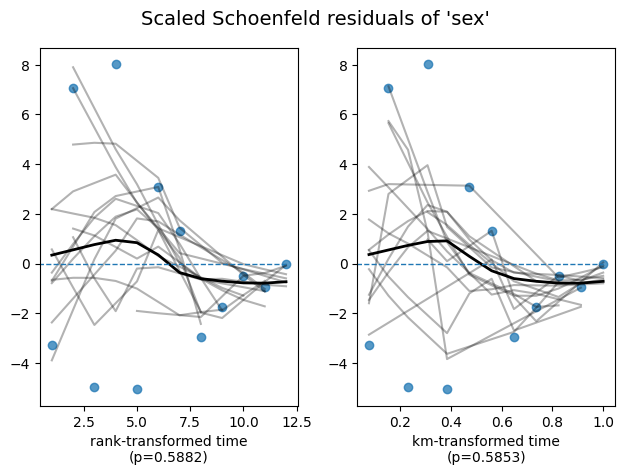

In [15]:
Model.check_assumptions(DatOriginal, plot_n_bootstraps=15, show_plots=True)